In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from statsmodels.stats.power import TTestIndPower, zt_ind_solve_power
from statsmodels.stats.weightstats import ztest, zconfint
from statsmodels.stats.proportion import proportion_confint
import seaborn as sns

## Зачем перед аб-тестом оценивать объём выборки?

In [2]:
days = 100

In [3]:
mu_control, sigma_control, n_control = 100, 20, 100
mu_experiment, sigma_experiment, n_experiment = 100, 20, 100

In [68]:
current_date = 1
user_data = pd.DataFrame()
stat_result = pd.DataFrame()
daily_data = pd.DataFrame()

In [69]:
for day in range(days):
    daily_data_control = np.random.normal(mu_control, sigma_control, n_control)
    daily_data_experiment = np.random.normal(mu_experiment, sigma_experiment, n_experiment)

    day_data_control = pd.DataFrame({'value': daily_data_control})
    day_data_control['date'] = current_date
    day_data_control['group'] = 'control'

    day_data_experiment = pd.DataFrame({'value': daily_data_experiment})
    day_data_experiment['date'] = current_date
    day_data_experiment['group'] = 'experiment'

    user_data = user_data._append(day_data_experiment)._append(day_data_control)
    fit = stats.ttest_ind(user_data[user_data.group == 'experiment'].value,
                          user_data[user_data.group == 'control'].value)

    stat_result = stat_result._append(pd.DataFrame({'t': [fit[0]], 
                                                    'p': [fit[1]], 
                                                    'date': current_date}))

    current_data_stat = user_data.groupby(['group'], as_index=False).agg({'value': 'mean'})
    current_data_stat['date'] = current_date

    daily_data = daily_data._append(current_data_stat)

    current_date += 1

C:\Users\Raz0ne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Raz0ne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


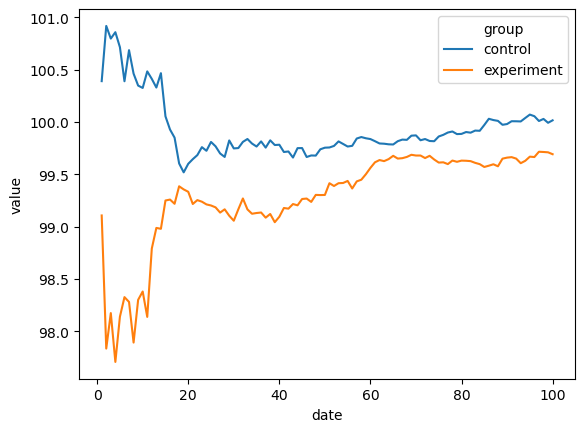

In [70]:
ax = sns.lineplot(data=daily_data, x='date', y='value', hue='group')

C:\Users\Raz0ne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Raz0ne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


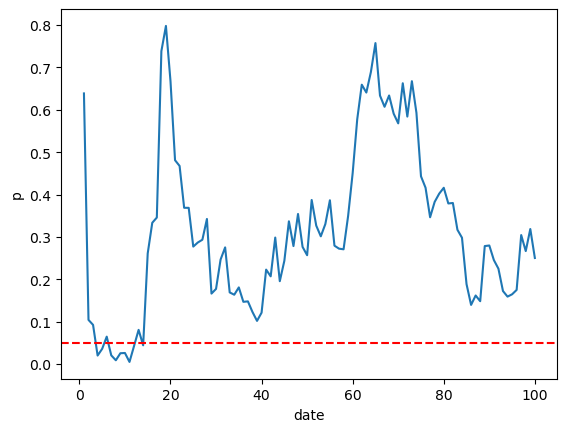

In [71]:
ax = sns.lineplot(data=stat_result, x='date', y='p')
ax.axhline(0.05, ls='--', color='red')

**Получается, что мы бы могли принять решение об успешности, хотя через несколько дней уровень значимости был бы опять больше 0.05**

### Мощность теста

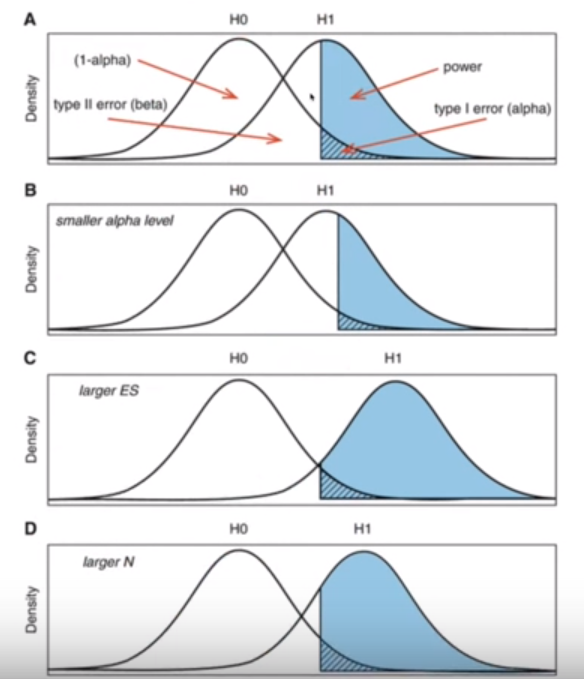

### Среднее

In [5]:
mean_test_data = pd.read_csv('t-test-data.csv')

In [6]:
mean_test_data.shape

(10000, 3)

In [7]:
mean_test_data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [8]:
mean_test_data['REVENUE'].mean()

0.09944700000000001

In [9]:
mean_test_data.groupby('VARIANT_NAME')['REVENUE'].mean()

VARIANT_NAME
control    0.129013
variant    0.070070
Name: REVENUE, dtype: float64

In [10]:
control_data = mean_test_data[mean_test_data['VARIANT_NAME'] == 'control']
targer_data = mean_test_data[mean_test_data['VARIANT_NAME'] == 'variant']

In [11]:
control_std = control_data['REVENUE'].std() / np.sqrt(len(control_data))

In [12]:
control_std

0.04260103087805793

### 1. Необходимый объём выборки

In [13]:
ttest_ind_power = TTestIndPower()

In [14]:
d = 0.005 / control_std
print(f'Effect size: {d}')

Effect size: 0.1173680518274805


In [15]:
# factors for power analysis
alpha = 0.01
power = 0.9

# perform power analysis to find sample size
# for given effect
obj = TTestIndPower()
n = obj.solve_power(effect_size=d, alpha=alpha, power=power,
                    ratio=1, alternative='two-sided')

In [16]:
n

2161.965379807801

### 2. AA-тест

In [17]:
alphas = []
for _ in range(1000):
    alphas.append(
        scipy.stats.ttest_ind(
            np.random.choice(control_data['REVENUE'], 7000),
            np.random.choice(control_data['REVENUE'], 7000))[1])

In [18]:
sum(np.array(alphas) < 0.05) / len(alphas)

0.051

### 3. Выводы по успешности аб-теста: стат-тест

In [19]:
scipy.stats.ttest_ind(targer_data['REVENUE'], control_data['REVENUE'])

TtestResult(statistic=-1.2711634519010084, pvalue=0.20370007853373565, df=9998.0)

## Доля (конверсия)

In [20]:
conversion_data = pd.read_csv('ab_data.csv')

In [22]:
conversion_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [23]:
conversion_data.shape

(294478, 5)

### 1. Необходимый объём выборки

In [25]:
conversion_data_control = conversion_data[conversion_data['group'] == 'control']
conversion_data_treatment = conversion_data[conversion_data['group'] == 'treatment']

In [26]:
conversion_data_control_std = conversion_data_control['converted'].std() \
    / np.sqrt(len(conversion_data_control['converted']))

In [27]:
conversion_data_control_std

0.0008482018124774152

In [28]:
conversion_data.groupby('group')['converted'].mean()

group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

In [29]:
effect_size = 0.0005 / conversion_data_control_std

In [30]:
effect_size

0.5894823527193457

In [34]:
zt_ind_solve_power(effect_size=effect_size, alpha=0.01, power=0.99,
                   ratio=1, alternative='two-sided')

138.31407821941391

### 2. AA-тест

In [35]:
conv_arr_aa_1 = scipy.stats.bernoulli.rvs(p=0.5, size=1000)

In [36]:
conv_arr_aa_2 = scipy.stats.bernoulli.rvs(p=0.5, size=1000)

In [37]:
conv_alphas = []
for _ in range(1000):
    conv_alphas.append(
        ztest(np.random.choice(conversion_data_control['converted'], 10000),
              np.random.choice(conversion_data_control['converted'], 10000))[1])

In [38]:
sum(np.array(conv_alphas) < 0.05) / len(conv_alphas)

0.044

### 3. Выводы по успешности аб-теста: z-тест

In [39]:
ztest(conversion_data_control['converted'], conversion_data_treatment['converted'])

(1.2369207675839395, 0.2161164992134198)